In [33]:
# # get json file with masks links to download and description  
# !gdrive download --path "/home/jupyter/data/" 1NyKLf3khaszjCUWKUnEnctg7v4YnGqae

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 26 18:01:51 2019

@author: GANESHA
"""
import json
import requests
from PIL import Image 
import numpy as np
import os
from io import BytesIO
import matplotlib.pyplot as plt
from itertools import groupby

In [3]:
# load the json file with labelbox files descriptors
with open('/home/jupyter/data/labeled_image_data_mask-2019-07-19T14_32_47.510Z.json') as f:
    data = json.load(f)

## Json description file analysis

In [4]:
## What are the possible Mask key combinations:
masks_dicts = []
for el in data:
    if 'Masks' in el:
        keys_list = []
        for keys in el['Masks']:
            keys_list.append(keys)
        masks_dicts.append(keys_list)

In [5]:
# out of above, what are the unique combinations:
output = []
for x in masks_dicts:
    if x not in output:
        output.append(x)
print('Unique sets of masks:')        
print(output)

Unique sets of masks:
[['lc_cat1', 'Non-agricultural (O)', 'Cloud'], ['Non-agricultural (O)'], ['lc_cat1', 'Cloud'], ['lc_cat1', 'Non-agricultural (O)'], ['lc_cat1'], ['Non-agricultural (O)', 'Cloud'], ['lc_cat1', 'Harvested land'], ['lc_cat1', 'Non-agricultural (O)', 'Harvested land'], ['Harvested land'], ['Non-agricultural (O)', 'Harvested land'], ['lc_cat1', 'Non-agricultural (O)', 'Cloud', 'Harvested land'], ['Cloud'], ['Non-agricultural (O)', 'Cloud', 'Harvested land'], ['lc_cat1', 'Cloud', 'Harvested land']]


In [6]:
unique_elements = []
for inner_l in masks_dicts:
    for item in inner_l:
        unique_elements.append(item)
unique_elements = set(unique_elements)
print('Unique Masks keys on the list: {}'.format(list(unique_elements)))

Unique Masks keys on the list: ['Non-agricultural (O)', 'Harvested land', 'Cloud', 'lc_cat1']


## Download masks and original files from Labelbox

Script by Sai with my minor changes. Credits to Sai.

In [199]:
print_ = False
if print_: print('lc_cat1')

In [223]:
%%time

#output_dir = ('/home/jupyter/data/WFP_Nepal_Scale3.5_RGB_and_masks_PNG/')
output_dir = ('/home/jupyter/data/WFP_Nepal_Scale3.5_RGB_and_masks_3cat_only_PNG/')
 
# selecting the unique IDs to have the unique pictures - gives 144 images at the end of this block
ids = []
ext_ids = []
idnots = []
 
for i in range(len(data)):
    if data[i]['External ID'] in ext_ids:
        idnots.append(data[i]['ID'])
    else :
        ext_ids.append(data[i]['External ID'])    
        ids.append(data[i]['ID'])    
        
files_generated = []
keys_used = []

print_ = True
save_ = True

# Just adapted from previous code available at private repo
# This section retrieves images and masks from Labelbox using JSON file
# At first I disregarded the "Unknown" category - just considered the "Trees" categories
for idx, d in enumerate(data):
    if d['ID'] in ids:
        if(d['Label']!='Skip'):
            if('Masks' in d):

                # print("Image: {}, ID: {}, filename: {}".format(idx, d["ID"], d["External ID"]))
                response_og = requests.get(d["Labeled Data"])
                img_og = Image.open(BytesIO(response_og.content))  

                # img_og.save(os.path.join(output_dir, '{}_original.png'.format(idx)), format='png')

                ## added LM to give same as original file names
                # file_name_base = '{}_{}'.format(str(idx), d["External ID"].rstrip('.png'))
                file_name_base = d["External ID"].rstrip('.png')
                
                if(save_):
                    img_og.save(os.path.join(output_dir, '{}_original.png'.format(file_name_base)), format='png')              

                # to check generated files.
                files_generated.append(file_name_base)
                print(d["External ID"])
                
                img_shape = np.array(img_og).shape 
                img_mask = np.zeros((img_shape[0], img_shape[1]))
                img_p1, img_p2, img_p3, img_p4 = np.zeros(img_mask.shape), np.zeros(img_mask.shape), np.zeros(img_mask.shape), np.zeros(img_mask.shape)

                threshold = 200
                print_ = False
                
                # Iterating over keys of a Mask key: 
                for key in d["Masks"]:
                    response = requests.get(d["Masks"][key])
                    img = Image.open(BytesIO(response.content)) 
                    
                    if print_: print(d["Masks"][key])
                    
                    if key in ['lc_cat1']:                        
                        if print_: print('lc_cat1')
                        keys_used.append('lc_cat1')
                        img_p1 = np.where(np.array(img)[:, :, 3] > threshold, 255, 0)
                        
#                     elif key in ['Non-agricultural (O)']:
#                         if print_: print('Non-agricultural (O)')
#                         keys_used.append('Non-agricultural (O)')
#                         img_p2 = np.where(np.array(img)[:, :, 3] > threshold, 255, 0)
                        
#                     elif key in ['Cloud']:
#                         if print_: print('Cloud')
#                         keys_used.append('Cloud')
#                         img_p3 = np.where(np.array(img)[:, :, 3] > threshold, 255, 0)
                        
#                     elif key in ['Harvested land']:
#                         if print_: print('Harvested land')
#                         img_p4 = np.where(np.array(img)[:, :, 3] > threshold, 255, 0)
#                         keys_used.append('Harvested land')

                img_p = img_p1# + img_p2 + img_p3 + img_p4 - np.where(img_p1 + img_p2 + img_p3 + img_p4 > 255, 255, 0)
                img_final = img_p
                img = Image.fromarray(img_final.astype(np.uint8)).convert(mode='L', dither=Image.NONE)
                
                # uncomment if you want to generate those files
                if(save_):
                    img.save(os.path.join(output_dir, '{}_mask.png'.format(file_name_base)), format='png')

## SUMMARY: 
# how many items per category:
files_generated_prefixes = [i.split('_')[0] for i in files_generated]
results = {value: len(list(freq)) for value, freq in groupby(sorted(files_generated_prefixes))}
print('Number of IDs in json file: {}\nValid files with masks {}\nNumber of file types generated per category: {}'.format(len(data), len(files_generated), results))

other_Oct16_84-52325558_27-65846061_img_1.png
other_Oct16_84-16754379_27-56137037_img_0.png
rice_Oct16_84-60718455_27-59681545_img_0.png
rice_Oct16_84-19222527_27-58901471_img_2.png
rice_Oct16_84-65810716_27-58414978_img_0.png
other_Oct16_84-52634599_27-58503432_img_1.png
other_Oct16_84-53437771_27-68448473_img_1.png
other_Oct16_84-24319208_27-5720005_img_0.png
rice_Oct16_84-27654487_27-60281297_img_1.png
other_Oct16_84-53853081_27-64843762_img_1.png
other_Oct16_84-26729258_27-62213752_img_0.png
wheat_Oct16_85-58982527_27-59543762_img_4.png
other_Oct16_84-21475618_27-56442798_img_0.png
rice_Oct16_84-63095536_27-60048573_img_0.png
rice_Oct16_84-21736073_27-58960318_img_2.png
other_Oct16_84-53186364_27-56847219_img_1.png
other_Oct16_84-23672198_27-5706473_img_0.png
rice_Oct16_84-28306358_27-59084298_img_1.png
other_Oct16_84-54004627_27-64970786_img_1.png
other_Oct16_84-28137767_27-4689098_img_0.png
wheat_Oct16_85-62475734_27-51448609_img_0.png
rice_Oct16_84-30097297_27-63492245_img_1.png

rice_Nov16_84-6147915_27-5800454_img_0.png
rice_Oct16_84-29680507_27-60001715_img_0.png
rice_Oct16_84-37780924_27-60645395_img_1.png
rice_Dec16_84-52494612_27-58182176_img_0.png
rice_Nov16_84-32226607_27-59022386_img_1.png
rice_Oct16_84-6462195_27-59293091_img_0.png
rice_Nov16_84-28187091_27-59074976_img_0.png
rice_Oct16_84-3351363_27-47906828_img_0.png
rice_Oct16_84-34292066_27-57389133_img_0.png
rice_Aug16_84-50416787_27-6085508_img_0.png
rice_Nov16_84-29680507_27-60001715_img_4.png
rice_Oct16_84-38822809_27-58394513_img_0.png
rice_Feb17_84-37780924_27-60645395_img_0.png
rice_Nov16_84-36765397_27-59654735_img_0.png
rice_Mar17_84-50416787_27-6085508_img_0.png
rice_Nov16_84-37780924_27-60645395_img_1.png
rice_Oct16_84-24091563_27-60358443_img_1.png
rice_Oct16_84-60281668_27-58572852_img_1.png
rice_Nov16_84-2765978_27-60418308_img_5.png
rice_Nov16_84-38279272_27-60176285_img_1.png
rice_Oct16_84-21606436_27-58950945_img_1.png
rice_Oct16_84-52494612_27-58182176_img_1.png
rice_Nov16_84-524

rice_Aug16_84-39229967_27-62457362_img_2.png
rice_Dec16_85-49218177_27-58979952_img_1.png
rice_Feb17_85-56732465_27-65065136_img_1.png
rice_Mar17_85-50286536_27-6576055_img_0.png
rice_Oct16_84-39229967_27-62457362_img_0.png
wheat_Jan17_85-58807426_27-6088233_img_1.png
rice_Aug16_84-41118127_27-6776455_img_0.png
rice_Dec16_85-53799504_27-56916064_img_1.png
rice_Feb17_85-62342205_27-62279302_img_0.png
rice_Mar17_85-54800333_27-57824736_img_0.png
rice_Oct16_84-40752061_27-6338849_img_1.png
wheat_Nov16_84-63212649_27-61521297_img_1.png
rice_Aug16_84-49445894_27-65349969_img_1.png
rice_Dec16_85-61511808_27-5971281_img_1.png
rice_Feb17_85-64360414_27-62886405_img_1.png
rice_Mar17_85-59214642_27-68256619_img_0.png
rice_Oct16_84-49427792_27-66250639_img_0.png
wheat_Nov16_85-55175923_27-67626909_img_8.png
rice_Aug16_84-54014659_27-65430335_img_0.png
rice_Dec16_85-65905639_27-60644277_img_0.png
rice_Feb17_85-76179576_27-6254203_img_2.png
rice_Mar17_85-64879022_27-6289598_img_0.png
rice_Oct16_84-

## Show created/final mask_file examples for different Masks :) 

In [238]:
file_list = []
file_ex = {}

## rice:

file_ex['name_original'] = 'rice_Oct16_84-50414508_27-60716998_img_2_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')

file_ex = {}
file_ex['name_original'] = 'rice_Oct16_84-60718455_27-59681545_img_0_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1 + Non-agricultural (O)'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')

file_ex = {}
file_ex['name_original'] = 'rice_Aug16_84-34730796_27-45671386_img_2_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1 + Non-agricultural (O) + Cloud'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')

file_ex = {}
file_ex['name_original'] = 'rice_Aug16_84-3006841_27-4779499_img_0_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1 + Non-agricultural (O) + Cloud + Harvested land'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')

file_ex = {}
file_ex['name_original'] = 'other_Oct16_84-1975653_27-57563301_img_2_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')

# ## WHEAT
# file_ex = {}
# file_ex['name_original'] = 'wheat_Oct16_85-78609013_27-57148097_img_2_original.png'
# file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
# file_ex['masks']  = 'lc_cat1'
# #print(file_ex)
# file_list.append(file_ex)
# #print(file_list)
# #print('----')


file_ex = {}
file_ex['name_original'] = 'wheat_Nov16_84-63212649_27-61521297_img_1_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1 + Harvested land'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')


### OTHER

file_ex = {}
file_ex['name_original'] = 'other_Oct16_84-57775994_27-70912416_img_2_original.png'
file_ex['name_mask'] = file_ex['name_original'].replace('_original', '_mask')
file_ex['masks']  = 'lc_cat1 + Non-agricultural (O) + Harvested land'
#print(file_ex)
file_list.append(file_ex)
#print(file_list)
#print('----')

## Comparison of exemplary masks generated with melted together Masks from labelbox (rice, Clouds, Harvested Land) vs only Base classe like rice/non rice, wheat/non wheat etc.

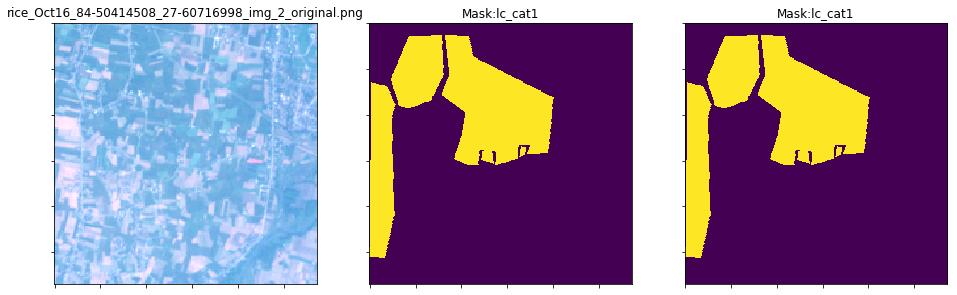

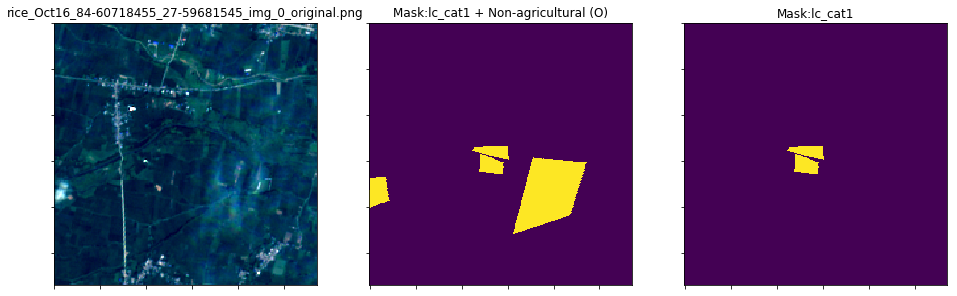

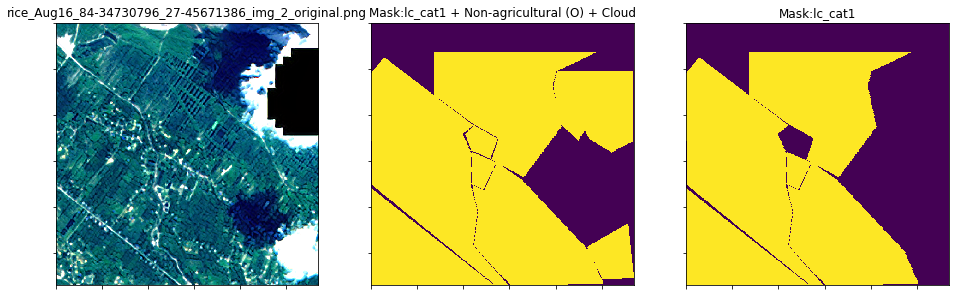

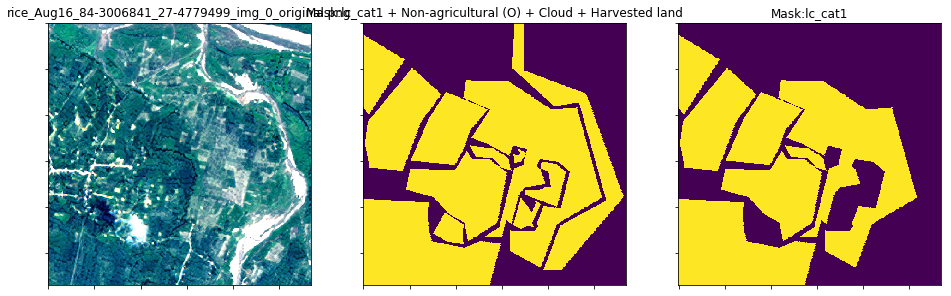

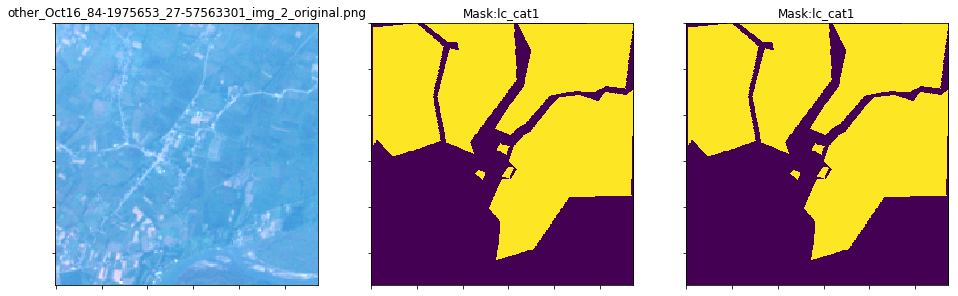

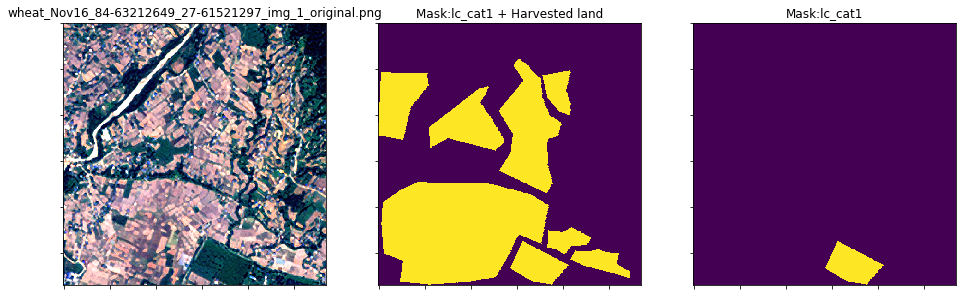

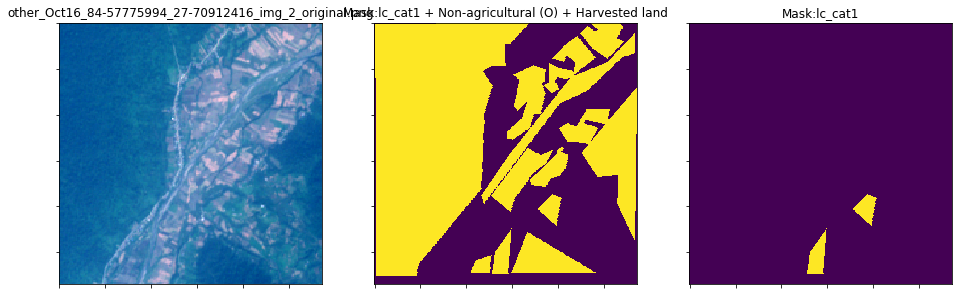

In [242]:
# create flipped versions of an image
from PIL import Image
from matplotlib import pyplot

output_dir_melted = ('/home/jupyter/data/WFP_Nepal_Scale3.5_RGB_and_masks_PNG/')
output_dir = ('/home/jupyter/data/WFP_Nepal_Scale3.5_RGB_and_masks_3cat_only_PNG/')

for file_ in file_list: #['other_Oct16_84-1975653_27-57563301_img_2_original.png', 'other_Oct16_84-1975653_27-57563301_img_2_mask.png']:

    #print(file_)
    # load image
    # print(file_['name_original'])
    image_orig = Image.open( output_dir_melted + file_['name_original'])
    image_mask_melted = Image.open( output_dir_melted + file_['name_mask'])
    image_mask = Image.open( output_dir + file_['name_mask'])
    
    plt.figure(figsize=(16,17))

    pyplot.subplot(1,3,1, title=file_['name_original'])
    pyplot.xticks(visible=False)
    pyplot.yticks(visible=False)
    pyplot.imshow(image_orig)
    
    pyplot.subplot(1,3,2, title='Mask:' + file_['masks'])
    pyplot.imshow(image_mask_melted)
    pyplot.xticks(visible=False)
    pyplot.yticks(visible=False)
    
    pyplot.subplot(1,3,3, title='Mask:' + 'lc_cat1')
    pyplot.imshow(image_mask)
    pyplot.xticks(visible=False)
    pyplot.yticks(visible=False)
    pyplot.show();

# import matplotlib.pyplot as plt

# plt.figure(num=None, figsize=(8, 6))

# path = output_dir + 'other_Oct16_84-16754379_27-56137037_img_0_original.png'
# im = Image.open(path)
# plt.imshow(im)
# plt.show()

# plt.figure(num=None, figsize=(8, 6))
# path = output_dir + 'other_Oct16_84-16754379_27-56137037_img_0_mask.png'
# im = Image.open(path)
# plt.imshow(im)
# plt.show()

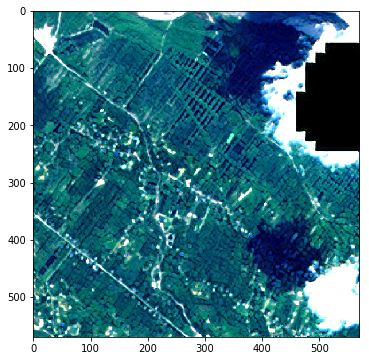

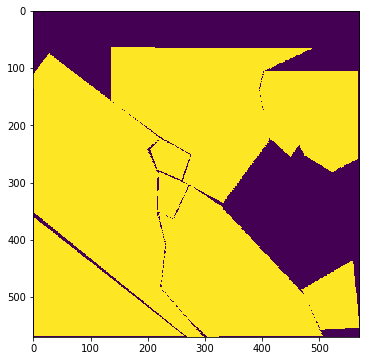

In [221]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6))

output_dir = ('/home/jupyter/data/WFP_Nepal_Scale3.5_RGB_and_masks_PNG/')
#output_dir = ('/home/jupyter/data/WFP_Nepal_Scale3.5_RGB_and_masks_3cat_only_PNG/')
 
filename_origin = 'rice_Aug16_84-34730796_27-45671386_img_2_original.png'

path = output_dir + filename_origin
im = Image.open(path)
plt.imshow(im)
plt.show()

plt.figure(num=None, figsize=(8, 6))
path = output_dir + filename_origin.replace('_original', '_mask')
im = Image.open(path)
plt.imshow(im)
plt.show()
